In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import  InputLayer, Conv2D, Lambda, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.signal import fft2d, ifft2d
import os
import numpy as np

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import random


In [4]:
np.random.seed = 42
IMG_WIDTH = 1920
IMG_HEIGHT = 1080
IMG_CHANNELS = 3


## Load Images

In [5]:
TRAIN_FILMED_PATH = "D:\\Main\\MA_PROGR\\Data\\Train\\UNet_Train\\water\\filmed"
TRAIN_CLEAN_PATH = "D:\\Main\\MA_PROGR\\Data\\Train\\UNet_Train\\water\\clean_aligned"
# TEST_PATH = "./Data/data-science-bowl-2018/stage1_test/"


In [6]:
train_filmed_imgs = []
train_clean_imgs = []

In [7]:
for addr_filmed in os.listdir(TRAIN_FILMED_PATH):
    img = plt.imread(f"{TRAIN_FILMED_PATH}\{addr_filmed}")
    train_filmed_imgs.append(img)

for addr_clean in os.listdir(TRAIN_CLEAN_PATH):
    img = plt.imread(f"{TRAIN_CLEAN_PATH}\{addr_clean}")
    train_clean_imgs.append(img)


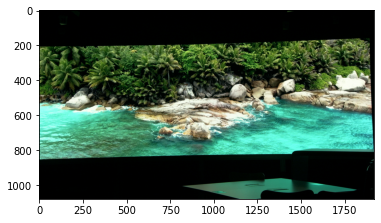

In [8]:
plt.imshow(train_filmed_imgs[0])
plt.show()


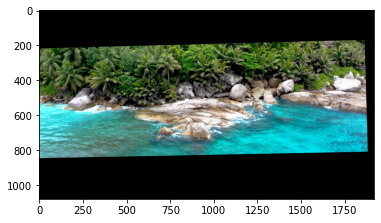

In [9]:
plt.imshow(train_clean_imgs[0])
plt.show()


## Build model

In [12]:
inputs = keras.Input(shape=(1, IMG_WIDTH, IMG_HEIGHT,
                    IMG_CHANNELS), batch_size=None, dtype=tf.float16)

# Hier werden Preprocessing-Schritte ausgeführt
# s ist hier dann Differnzbild (Pixelraum_Fourier)
# s = Lambda(lambda x: x / 255)(inputs)


# Contraction path
c1 = Conv2D(
    16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = Conv2DTranspose(
    128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(
    64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(
    32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(
    16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

u_net_model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer='adam', loss='binary_crossentropy',
#               metrics=['accuracy'])
u_net_model.summary()


ValueError: Input 0 of layer max_pooling2d is incompatible with the layer: expected ndim=4, found ndim=5. Full shape received: (None, 1, 1920, 1080, 16)

## Train Model

In [ ]:
# Custom train loop

num_epochs = 1
optimizer = tf.keras.optimizers.Adam()
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn = tf.keras.losses.binary_crossentropy
acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()


for epoch in range(num_epochs):
    print(f"Start of epoch {epoch}")
    # X_train: müsste bei mir ein Iterator sein, welcher 1 Bild zurückgibt (1, 128, 128, 3)
    for x_filmed, x_clean in tqdm(zip(train_filmed_imgs, train_clean_imgs), desc="training...", ascii=False, ncols=75):


        with tf.GradientTape() as tape:
            # Start Preprocessing: RGB_clean, RGB_filmed (könnte man irgendwo implementieren - normales Python)
                ## Input: Fourier_clean und Fourier_filmed  (Datatype: tf.complex)
                    ## fft2(RGB_clean), fft2(RGB_filmed)
                ## Erster Schritt:  Fourier_clean - Fourier_filmed (im komplexen Raum? Bisher im Pixel_Fourier)
            x_filmed_fourier = fft2d(x_filmed)
            x_clean_fourier = fft2d(x_clean)

            

            # HIER STARTET MODEL (UNet)
            # c1(Differenzbild)
            # y_pred: Segmentierungsmaske (weights anpassen) U-Net (als Blackbox verwenden!)
                ## Output: leicht verändertes Differenzbild (Werte zwischen 0..1 -> Sigmoid)
            # HIER ENDET MODEL (UNet)
            
            u_net_output = u_net_model(
                x_batch.reshape(-1, 128, 128, 3), training=True)

            # -> Alpha Blending "soft" (alternativ die Funktionen aus Facilities verwenden)(reine Berechnung)
                ## Input: Differenzbild UND zwei Variablen (tf.Placeholder) für Fourier_clean und Fourier_filmed
            # -> result = ifft (reine Berechnung)
                ## Input: Fourier_processed Output: Bild in RGB-Domain

            # ALIASING-CNN verwenden
            # predict_aliasing(result) (nicht die weights verändern!)
                ## Input: RGB/Bild    Output: 2D Matrix mit 0..1 Wahrscheinlichkeiten für Aliasing

            # loss funktion 
                ## Loss wird pro Kachel berechnet
                ## Fake Fake_lables: ausschließlich kein Aliasing! -> 2D Matrix mit 0
                ## y_pred = Kacheln
                ## crossentropy -> loss_fn(Fake_lables, y_pred)

            # HIGH-LEVEL Programmierung
            # rgb_processed = alpha_blending(u_net_output, rgb_clean_fft, rgb_filmed_fft)
            # y_pred = cnn_model(rgb_processed, training=False)
            # loss = loss_fn(y_pred, fake_labels)
            # gradients = tape.gradient(loss, model.trainable_weights)
            # optimizer.apply_gradients(zip(gradients, model.trainable_weights))


            loss = loss_fn(y_batch.reshape(-1, 128, 128, 1), u_net_output)

        gradients = tape.gradient(loss, u_net_model.trainable_weights)
        optimizer.apply_gradients(
            zip(gradients, u_net_model.trainable_weights))
        acc_metric.update_state(
            y_batch.reshape(-1, 128, 128, 1), u_net_output)

    train_acc = acc_metric.result()
    print(f"Accuracy over epoch {train_acc}")
    acc_metric.reset_states()


Start of epoch 0


training...: 670it [02:05,  5.35it/s]


Accuracy over epoch 0.7995051741600037
